In [1]:
# coding: utf-8    #  par défaut l'encoding est en utf-8 pour python 3

# Import des librairies
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pylab
import re
import time
from sklearn import decomposition
from sklearn import preprocessing
from math import *
from datetime import date


In [2]:
# Changer la taille de police par défaut
plt.rcParams.update({'font.size': 15})

In [3]:
pd.set_option('display.max_row', 2000)
pd.set_option('display.max_column', 300)
pd.set_option('display.column_space', 200)

pd.set_option('display.width', 10000)   # pas encore essayé


In [4]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 50


<IPython.core.display.Javascript object>

### Clients

In [5]:
customers = pd.read_csv("customers.csv")
print(customers.shape)

# A RETENIR :   customer_id , customer_unique_id
customers = customers.drop(['customer_zip_code_prefix', 'customer_city', 'customer_state'], 1)
customers.head(2)


(99441, 5)


,customer_id,customer_unique_id
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3


### Commandes

In [6]:
orders = pd.read_csv("orders.csv")
print("Shape :", orders.shape)

# Ajout de la variable 'customer_unique_id' au dataframe 'orders'
orders = pd.merge(orders, customers, on='customer_id')

# Supression des commandes non valides :
orders = orders[~orders['order_status'].isin(['unavailable','canceled'])]

# Nettoyage colonnes
orders = orders.drop(['customer_id','order_status','order_purchase_timestamp','order_delivered_carrier_date',
                      'order_delivered_customer_date','order_estimated_delivery_date'], 1)

# suppression des orders avec NaN localisés sur la colonne 'order_approved_at' :
orders = orders.dropna(how = 'any')
print("Après suppression des commandes sans 'date'", orders.shape)

# Liste des commandes valides
l_validated_orders = orders['order_id'].unique().tolist()

# Renommage colonnes
orders.columns = ['order_id', 'date', 'customer_id']

orders.head(2)


Shape : (99441, 8)
Après suppression des commandes sans 'date' (98188, 3)


,order_id,date,customer_id
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 11:07:15,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-26 03:24:27,af07308b275d755c9edb36a90c618231


In [7]:
# Formatage de la date

import datetime
from datetime import timedelta

orders['date'] = pd.to_datetime(orders['date'])   # object >> datetime64

debut_periode = orders['date'].min()
fin_periode   = orders['date'].max()

orders['date'] = orders['date'].dt.date   # enlève les heures, minutes, secondes

# orders['date'] = pd.to_datetime(orders['date'])   # object >> datetime64

print("Commande la plus récente  :", fin_periode)
print("Commande la plus ancienne :", debut_periode)


Commande la plus récente  : 2018-09-03 17:40:06
Commande la plus ancienne : 2016-09-15 12:16:38


In [8]:
# Liste des clients ayant commandé plus d'une fois :
l_customer_multip = orders[orders.duplicated(subset = ['customer_id'])]['customer_id'].unique()


### Lignes de commande

In [11]:
items = pd.read_csv("order_items.csv")

# A RETENIR :   order_id , product_id , price , freight_value

# Suprimmer les lignes de commandes des commandes non valides :
items = items[items['order_id'].isin(l_validated_orders)]

items = items.drop(['shipping_limit_date','seller_id','order_item_id'], 1)
items.columns = ['order_id', 'product_id', 'price', 'freight']              # Renommage colonnes

print(items.shape)
items.head(3)


(112086, 4)


,order_id,product_id,price,freight
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,199.0,17.87


### Produits

In [12]:
products = pd.read_csv("products.csv")


# A RETENIR :   product_id , product_weight_g , product_length_cm , product_height_cm , product_width_cm

products = products.drop(['product_category_name','product_name_lenght','product_description_lenght','product_photos_qty'], 1)

products.columns = ['product_id','weight','length','height','width']

products['volume']= products['length'] * products['height'] * products['width']

products = products.dropna(how = 'any')                     
# 2 produits n'ont pas de 'product_weight_g', 'product_length_cm' , 'product_height_cm' , 'product_width_cm'

products.head(3)

,product_id,weight,length,height,width,volume
0,1e9e8ef04dbcff4541ed26657ea517e5,225.0,16.0,10.0,14.0,2240.0
1,3aa071139cb16b67ca9e5dea641aaa2f,1000.0,30.0,18.0,20.0,10800.0
2,96bd76ec8810374ed1b65e291975717f,154.0,18.0,9.0,15.0,2430.0


### Paiements

In [13]:
# Type paiement :  'credit_card', 'boleto', 'voucher', 'debit_card', 'not_defined'

# Vérifier qu'une commande => un type de paiement

payments = pd.read_csv("order_payments.csv")
print(payments.shape)
print(payments.head(2))


(103886, 5)
                           order_id  payment_sequential payment_type  payment_installments  payment_value
0  b81ef226f3fe1789b1e8b2acac839d17                   1  credit_card                     8          99.33
1  a9810da82917af2d9aefd1278f1dcfa0                   1  credit_card                     1          24.39


In [14]:
# Supression des paiements indéfinis :
payments = payments[~payments['payment_type'].isin(['not_defined'])]

# Supression des paiements liés aux commandes invalides :
payments = payments[payments['order_id'].isin(l_validated_orders)]

In [15]:
print("Shape :", payments.shape, "\n")

# Liste des commandes multi-paiements :
l_order_multip = payments[payments.duplicated(subset = ['order_id'])]['order_id'].unique()


Shape : (102554, 5) 



In [16]:
# Pour récupérer le type de paiement ('payment_type') :
Paiement_first = payments.sort_values(['order_id', 'payment_sequential'], ascending = True)   # 1,2,3,4,5...
Paiement_first.drop_duplicates(subset ="order_id", keep = 'first', inplace=True)
Paiement_first = Paiement_first.drop(['payment_sequential','payment_installments','payment_value'], 1)

# Pour récupérer le nombre de paiements ('payment_sequential') :
Paiement_last = payments.sort_values(['order_id', 'payment_sequential'], ascending = True)
Paiement_last.drop_duplicates(subset ="order_id", keep = 'last', inplace=True)
Paiement_last = Paiement_last.drop(['payment_type','payment_installments','payment_value'], 1)
Paiement_last.columns = ['order_id', 'nb_payments']

payments = pd.merge(Paiement_first, Paiement_last, on='order_id')
print(payments['nb_payments'].unique())
payments.head(3)


[ 1  2  6  3  7  4  5 11 12 10 15  8  9 22 14 13 21 26 19 29]


,order_id,payment_type,nb_payments
0,00010242fe8c5a6d1ba2dd792cb16214,credit_card,1
1,00018f77f2f0320c557190d7a144bdd3,credit_card,1
2,000229ec398224ef6ca0657da4fc703e,credit_card,1


### Encodage de la variable 'payments.payment_type'

In [17]:
from sklearn.preprocessing import OneHotEncoder

# 1. Encodage
X = payments[['payment_type']]   # Choix des variables à encoder
                                          
encoder = OneHotEncoder()
X_encoded = encoder.fit_transform(X).toarray()

# 2. Reconstitution du dataframe 'products'
col = encoder.get_feature_names(['payment_type'])   # Récupérer les colonnes crées par OneHotEncoder

# Convertir le 'numpy.ndarray' en un dataframe :
df_X = pd.DataFrame(data=X_encoded, index=payments.index, columns=col)

# Supprimer les colonnes traitées par OneHotEncoder ...
payments_enc = payments.drop(['payment_type'], 1) 

# ... et les remplacer par leurs équivalents OneHotEncoder :
payments = payments_enc.join(df_X)
print(payments.shape)
payments.head(2)


(98187, 6)


,order_id,nb_payments,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher
0,00010242fe8c5a6d1ba2dd792cb16214,1,0.0,1.0,0.0,0.0
1,00018f77f2f0320c557190d7a144bdd3,1,0.0,1.0,0.0,0.0


## Formation du dataset

In [23]:
#  Table maitresse 'items' : ['order_id', 'product_id', 'price', 'freight_value']

#  Aggrégation des caractéristiques des Produits :  ['weight', 'length', 'height', 'width']
data_rfm = pd.merge(items, products, on='product_id')
data_rfm = data_rfm.drop(['product_id'], 1)   # 'product_id' n'est plus utile

#  Regroupement des lignes de commande par commande :
data_rfm = data_rfm.groupby(['order_id']).sum().reset_index()

data_rfm.head(2)

,order_id,price,freight,weight,length,height,width,volume
0,00010242fe8c5a6d1ba2dd792cb16214,58.9,13.29,650.0,28.0,9.0,14.0,3528.0
1,00018f77f2f0320c557190d7a144bdd3,239.9,19.93,30000.0,50.0,30.0,40.0,60000.0


### Constitution des dataframes par période

In [24]:
# Sauvegarde avant constitution du dataset principal :
temp_orders = orders.copy()
temp_df     = data_rfm.copy()


### Filtre sur la période

In [25]:
# Calcul de la Récence aprés sélection de la dernière date de commande pour chaque client.
#
# La fonction calcul_recence() est appelée pour chacune des 10 périodes (cellule suivante).

import datetime

def calcul_recence(orders):
    customer_date = orders.sort_values(['customer_id','date'], ascending = False)
    customer_date.drop_duplicates(subset ="customer_id", keep = 'first', inplace=True)   # On ne garde que la date la + récente
    customer_date = customer_date.drop(['order_id'], 1)

    date_ref = datetime.date(2018, 9, 5)   # date de référence

    customer_date['date'] = date_ref - customer_date['date']    # calcul récence (différence en jours)
    customer_date.columns = ['recence', 'customer_id']          # Renommage colonnes

    customer_date['recence'] = customer_date['recence'].dt.days.astype('int16')
    return(customer_date)


In [26]:
# Constitution de la liste des dates limites des 10 périodes :

print("Commandes du  ", debut_periode,"  au  ", fin_periode,"\n")
 
list_dates_limit = []
date01 = datetime.date(2017, 12, 1); list_dates_limit.append(date01)
date02 = datetime.date(2018, 1,  1); list_dates_limit.append(date02)
date03 = datetime.date(2018, 2,  1); list_dates_limit.append(date03)
date04 = datetime.date(2018, 3,  1); list_dates_limit.append(date04)
date05 = datetime.date(2018, 4,  1); list_dates_limit.append(date05)
date06 = datetime.date(2018, 5,  1); list_dates_limit.append(date06)
date07 = datetime.date(2018, 6,  1); list_dates_limit.append(date07)
date08 = datetime.date(2018, 7,  1); list_dates_limit.append(date08)
date09 = datetime.date(2018, 8,  1); list_dates_limit.append(date09)
date10 = datetime.date(2018, 9,  4); list_dates_limit.append(date10)

print("Date limite supérieure des périodes de 1 à 10:")
for datex in list_dates_limit:
    print(datex)


Commandes du   2016-09-15 12:16:38   au   2018-09-03 17:40:06 

Date limite supérieure des périodes de 1 à 10:
2017-12-01
2018-01-01
2018-02-01
2018-03-01
2018-04-01
2018-05-01
2018-06-01
2018-07-01
2018-08-01
2018-09-04


In [27]:
# Constitution du dataset principal en fonction des différentes périodes :

import copy


l_customer_ref = []
dict_clients_period = {}
first = True

for datex in list_dates_limit:
    
    # Prise en compte des commandes passées avant la date limite 'datex'
    orders2 = temp_orders[temp_orders.date < datex]
    print(len(orders2),"commandes jusqu'au", datex)

    #  1. Aggrégation des caractéristiques des Paiements : 
    data_rfm = pd.merge(temp_df, payments, on='order_id')
    
    # 2. Préparation du Calcul de la Fréquence de commande :  Une commande a une fréquence de 1
    data_rfm['frequence'] = 1
    data_rfm = pd.merge(data_rfm, orders2[['order_id', 'customer_id']])   # pour récupérer 'customer_id'
      
    # 3. Dataframe sans 'order_id','length','height','width' :
    data_rfm = data_rfm[['customer_id','price','freight','weight','volume','nb_payments', 'frequence',
                         'payment_type_boleto', 'payment_type_credit_card','payment_type_debit_card','payment_type_voucher']]    

    #  4. Regroupement des commandes par client
    data_rfm = data_rfm.groupby(['customer_id']).aggregate(
    {'customer_id': 'min',
     'price': ['mean', 'min', 'max'],
     'freight': ['mean'], 'weight': ['mean'],
     'volume': ['mean'],
     'nb_payments': ['mean'],
     'frequence': ['sum'],
     'payment_type_boleto': ['mean'], 'payment_type_credit_card': ['mean'],
     'payment_type_debit_card': ['mean'],'payment_type_voucher': ['mean'] })

    data_rfm.columns = data_rfm.columns.droplevel(level=[0])
    data_rfm.columns = ['customer_id', 'price', 'price_min', 'price_max', 'freight', 'weight', 
                    'volume', 'nb_payments', 'frequence',
                    'payment_boleto', 'payment_credit_card', 'payment_debit_card','payment_voucher']
    data_rfm.reset_index(drop = True, inplace = True)


    #  5. Aggrégation de la 'recence' après son calcul :
    customer_date = calcul_recence(orders2)
    clients = pd.merge(data_rfm, customer_date, on='customer_id')
    
    # 6. Contrôle des clients :
    if first == True:
        first = False
        clients = clients[clients['customer_id'].isin(l_customer_multip)]  # restriction aux clients multi-commandes
        l_customer_ref = clients['customer_id'].unique()                   # Liste des clients référents
    else:
        clients = clients[clients['customer_id'].isin(l_customer_ref)]     # on doit avoir les même clients 
    print("pour", len(clients), "clients\n")
    
    # 7. Sauvegarde du dataframe d'UNE période :
    dict_clients_period[datex] = copy.deepcopy(clients)


# Nombre total de clients multi-commandes = len(l_customer_multip) = 2886 pour 99441 clients


38818 commandes jusqu'au 2017-12-01
pour 1677 clients

44600 commandes jusqu'au 2018-01-01
pour 1677 clients

51708 commandes jusqu'au 2018-02-01
pour 1677 clients

58312 commandes jusqu'au 2018-03-01
pour 1677 clients

65561 commandes jusqu'au 2018-04-01
pour 1677 clients

72319 commandes jusqu'au 2018-05-01
pour 1677 clients

79345 commandes jusqu'au 2018-06-01
pour 1677 clients

85487 commandes jusqu'au 2018-07-01
pour 1677 clients

91612 commandes jusqu'au 2018-08-01
pour 1677 clients

98188 commandes jusqu'au 2018-09-04
pour 1677 clients



## Transformation des variables

In [28]:
# 1. RACINE
col_racine =  ['price', 'price_min', 'price_max', 'freight', 'weight', 'volume', 'nb_payments', 'frequence', 'recence',
              'payment_boleto', 'payment_credit_card', 'payment_debit_card', 'payment_voucher']
for datex in list_dates_limit:
    #print("Date limite :", datex)
    periode = dict_clients_period[datex]          # Extraction d'un dataframe d'une période (= un mois)
    for col in col_racine:      
        periode[col] = np.sqrt(periode[col])


# 2. STANDARDISATION
col_std =  ['price', 'price_min', 'price_max', 'freight', 'weight', 'volume', 'nb_payments', 'frequence', 'recence',
              'payment_boleto', 'payment_credit_card', 'payment_debit_card', 'payment_voucher']
for datex in list_dates_limit:
    #print("Date limite :", datex)
    periode = dict_clients_period[datex]
    for col in col_std:      
        periode[col] = (periode[col] - periode[col].mean()) / periode[col].std(ddof = 0)


### Choix des Variables

In [29]:
# --- 1. VARIABLES :

list_var =   ['price', 'price_min', 'price_max', 'freight', 'weight', 'volume', 'nb_payments', 'frequence', 'recence',
              'payment_boleto', 'payment_credit_card', 'payment_debit_card', 'payment_voucher']


# Choix de la Méthode optimale

## Classification hiérarchique

In [50]:
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn import metrics


for datex in list_dates_limit:
    UNE_period = dict_clients_period[datex]          # extraction du dataframe d'UNE période
    X = UNE_period[list_var].values

    # Clustering hiérarchique
    Z = linkage(X, 'ward')

    # Decoupage du dendrogramme en 'x' clusters :
    x = 6
    clusters = fcluster(Z, x, criterion='maxclust')   # (Option : criterion='distance')
    
    # Sauvegarde des clusters d'UNE période :
    UNE_period['cluster'] = clusters
    dict_clients_period[datex] = UNE_period   # chaque client de la période a maintenant son cluster

    

first = True
rand_score = []
dict_score = {}

for datex in list_dates_limit:
    
    if first == True:
        first = False
    else:
        #print("Jusqu\'au ", date_prev," et ", datex)
        period_courant = dict_clients_period[datex]           # dataframe de la période courante
        period_prev    = dict_clients_period[date_prev]       # dataframe dde la période precedante
            
        rand_score.append(metrics.adjusted_rand_score(period_prev['cluster'], period_courant['cluster']))
        
        dict_score[datex] = metrics.adjusted_rand_score(period_prev['cluster'], period_courant['cluster'])
        
    date_prev = datex

print("Rand Score ajusté CAH :\n", rand_score)


Rand Score ajusté CAH :
 [0.7057713285158207, 0.530955025122087, 0.6859823381790201, 0.5344316800164228, 0.6112353971663628, 0.6354227670292258, 0.6918619630852765, 0.698600409339131, 0.570265182992805]


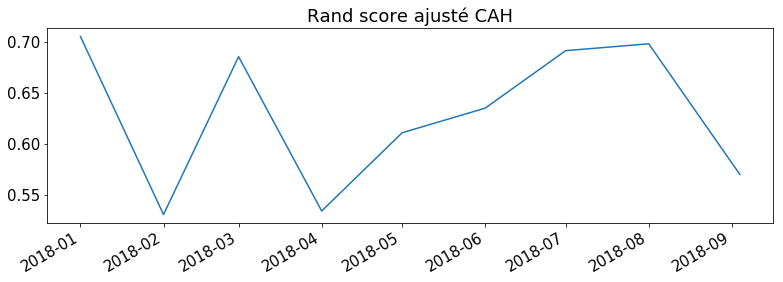

In [51]:
# Affichage de l'évolution du rand score ajusté

import matplotlib.dates as mdates


df_score = pd.DataFrame(list(dict_score.items()),  columns=['date', 'score'])

df_score['datetime'] = pd.to_datetime(df_score['date'])
value_month = df_score[['datetime', 'score']].copy()
value_month.set_index('datetime', inplace=True)

fig, ax = plt.subplots(figsize=(13, 4))
ax.plot(value_month.index, value_month.values)
fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m')
ax.set_title('Rand score ajusté CAH')
fig.savefig("rand_score_cah")
plt.show()


## Clustering K-means

In [58]:
from sklearn.cluster import KMeans
from sklearn import metrics


for datex in list_dates_limit:
    UNE_period = dict_clients_period[datex]          # extraction du dataframe d'UNE période
    X = UNE_period[list_var].values

    n_clust = 6
    km = KMeans(n_clusters=n_clust)   # Clustering K-means
    km.fit(X)
    clusters = km.labels_

    # Sauvegarde des clusters d'UNE période :
    UNE_period['cluster'] = clusters
    dict_clients_period[datex] = UNE_period   # chaque client de la période a maintenant son cluster

    

first = True
rand_score = []
dict_score = {}

for datex in list_dates_limit:
    
    if first == True:
        first = False
    else:
        #print("Jusqu\'au ", date_prev," et ", datex)
        period_courant = dict_clients_period[datex]           # dataframe de la période courante
        period_prev    = dict_clients_period[date_prev]       # dataframe dde la période precedante
            
        rand_score.append(metrics.adjusted_rand_score(period_prev['cluster'], period_courant['cluster']))
        
        dict_score[datex] = metrics.adjusted_rand_score(period_prev['cluster'], period_courant['cluster'])
        
    date_prev = datex

print("Rand Score ajusté Kmeans :\n", rand_score)


Rand Score ajusté Kmeans :
 [0.38494563333202203, 0.38715522285374643, 0.8808270720970123, 0.8896076571233484, 0.9318398485646812, 0.9171811632121613, 0.8726648998308915, 0.9175117626144416, 0.7925649541771771]


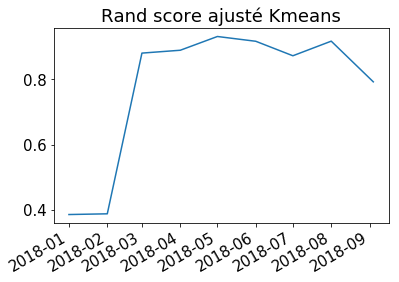

In [59]:
# Affichage de l'évolution du rand score ajusté

df_score = pd.DataFrame(list(dict_score.items()),  columns=['date', 'score'])

df_score['datetime'] = pd.to_datetime(df_score['date'])
value_month = df_score[['datetime', 'score']].copy()
value_month.set_index('datetime', inplace=True)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(value_month.index, value_month.values)
fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m')
ax.set_title('Rand score ajusté Kmeans')
fig.savefig("rand_score_kmeans")
plt.show()


### Clustering DBSCAN  

In [72]:
from sklearn.cluster import DBSCAN
from sklearn import metrics


for datex in list_dates_limit:
    UNE_period = dict_clients_period[datex]          # extraction du dataframe d'UNE période
    X = UNE_period[list_var].values
    
    db = DBSCAN(eps=3.8, min_samples=8)   # Clustering DBSCAN
    db.fit(X)
    clusters = db.labels_

    # Sauvegarde des clusters d'UNE période :
    UNE_period['cluster'] = clusters
    dict_clients_period[datex] = UNE_period   # chaque client de la période a maintenant son cluster
    

first = True
rand_score = []
dict_score = {}

for datex in list_dates_limit:
    
    if first == True:
        first = False
    else:
        #print("Jusqu\'au ", date_prev," et ", datex)
        period_courant = dict_clients_period[datex]           # dataframe de la période courante
        period_prev    = dict_clients_period[date_prev]       # dataframe dde la période precedante
            
        rand_score.append(metrics.adjusted_rand_score(period_prev['cluster'], period_courant['cluster']))
        
        dict_score[datex] = metrics.adjusted_rand_score(period_prev['cluster'], period_courant['cluster'])
        
    date_prev = datex

print("Rand Score ajusté DBSCAN :\n", rand_score)
    

Rand Score ajusté DBSCAN :
 [0.9570920131824, 0.9709413661202604, 0.9587937250068502, 0.993403991721035, 0.9730711571797145, 0.980799165437442, 0.9872883478371389, 0.9577686954198416, 0.9768882039100671]


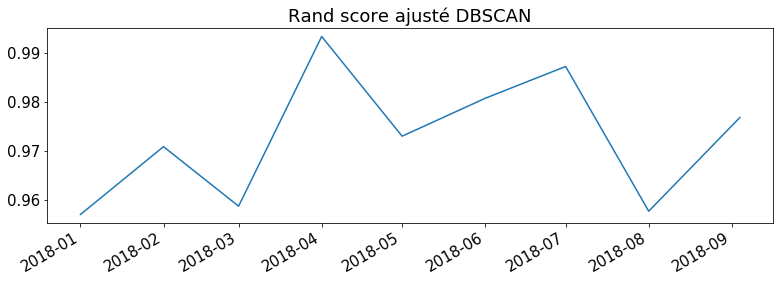

In [73]:
# Affichage de l'évolution du rand score ajusté

df_score = pd.DataFrame(list(dict_score.items()),  columns=['date', 'score'])

df_score['datetime'] = pd.to_datetime(df_score['date'])
value_month = df_score[['datetime', 'score']].copy()
value_month.set_index('datetime', inplace=True)

fig, ax = plt.subplots(figsize=(13, 4))
ax.plot(value_month.index, value_month.values)
fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m')
ax.set_title('Rand score ajusté DBSCAN')
fig.savefig("rand_score_dbscan")
plt.show()


# Stabilité des segments

In [66]:
from sklearn.cluster import DBSCAN
from sklearn import metrics


for datex in list_dates_limit:
    UNE_period = dict_clients_period[datex]          # extraction du dataframe d'UNE période
    X = UNE_period[list_var].values
    
    db = DBSCAN(eps=3.8, min_samples=8)   # Clustering DBSCAN
    db.fit(X)
    clusters = db.labels_

    # Sauvegarde des clusters d'UNE période :
    UNE_period['cluster'] = clusters
    dict_clients_period[datex] = UNE_period   # chaque client de la période a maintenant son cluster
    

first = True
rand_score = []
dict_score = {}

for datex in list_dates_limit:
    
    if first == True:
        first = False
        period_01    = dict_clients_period[datex]             # dataframe de la 1ère période
    else:
        #print("Jusqu\'au ", date_prev," et ", datex)
        period_courant = dict_clients_period[datex]           # dataframe de la période courante
            
        rand_score.append(metrics.adjusted_rand_score(period_01['cluster'], period_courant['cluster']))
        
        dict_score[datex] = metrics.adjusted_rand_score(period_01['cluster'], period_courant['cluster'])
        
    date_prev = datex

print("Rand Score ajusté DBSCAN :\n", rand_score)


Rand Score ajusté DBSCAN :
 [0.9570920131824, 0.9278154494364957, 0.9025162394773087, 0.8962439220175273, 0.8839638190098733, 0.8912272012850394, 0.879130835052269, 0.8389244500498483, 0.8281605120039277]


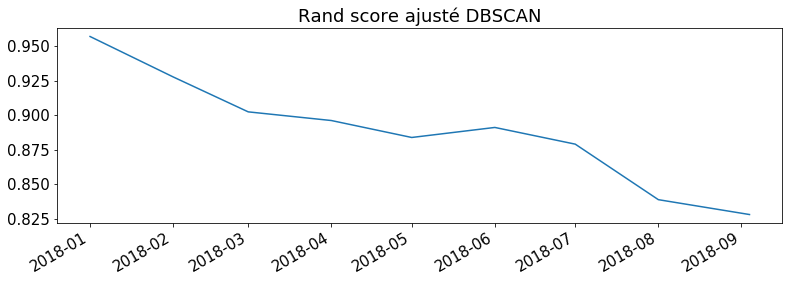

In [67]:
# Affichage de l'évolution du rand score ajusté

df_score = pd.DataFrame(list(dict_score.items()),  columns=['date', 'score'])

df_score['datetime'] = pd.to_datetime(df_score['date'])
value_month = df_score[['datetime', 'score']].copy()
value_month.set_index('datetime', inplace=True)

fig, ax = plt.subplots(figsize=(13, 4))
ax.plot(value_month.index, value_month.values)
fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m')
ax.set_title('Rand score ajusté DBSCAN')
fig.savefig("rand_score_2")
plt.show()